# Introduction

In this notebook, we will predict the remaining useful life (RUL) of a battery and visualize the prediction uncertainty by using a visualization technique called hypothetical outcome plots. 

Specifically, we will create an animation that displays various possible battery degradation trajectories. 

In this case study, we will demonstrate how hypothetical outcome plots highlight the **risk** of battery failure after certain usage time. This could be especially helpful when communicating prediction uncertainties to decision-makers, as hypothetical outcome plots allow decision-makers to directly *experience* risk, which would otherwise be asbtract and hard to interpret.

In [3]:
# import all packages and set plots to be embedded inline
import numpy as np
from scipy.integrate import quad
import sklearn.gaussian_process as gp
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
from celluloid import Camera
from numpy import genfromtxt
import pandas as pd
import os

%matplotlib inline
np.set_printoptions(precision=2,suppress=True)
np.random.seed(42)

# Physical background

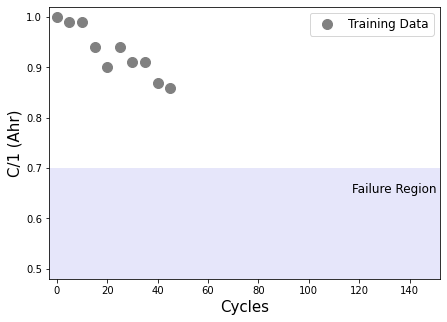

In [2]:
# Training data
X_train = np.arange(0,46,5)
y_train = np.array([1.,0.99,0.99,0.94,0.9,0.94,0.91,0.91,0.87,0.86])


# Visualizing training data
fig, ax = plt.subplots(figsize=(7,5))
ax.set(xlim=(-3, 152), ylim=(0.48, 1.02))
ax.plot(X_train,y_train,'o',color=(0.5,0.5,0.5),markerfacecolor=(0.5,0.5,0.5),markersize=10,label='Training Data')

# Risk region
shade_x = np.arange(-3,153)
shade_upper = 0.7*np.ones(shade_x.shape[0])
shade_lower = 0.46*np.ones(shade_x.shape[0])
ax.fill_between(shade_x, shade_upper, shade_lower,facecolor='lavender')
ax.text(117,0.65,'Failure Region', fontsize=12)

# Figure settings
ax.set_xlabel('Cycles', fontsize=15)
ax.set_ylabel('C/1 (Ahr)', fontsize=15)
ax.legend(loc="upper right",prop={'size': 12});

In [66]:
# Monte Carlo simulation of degradation paths
def degradation_path_ensemble(target_cycle, samples):
    """Thie function calculates the battery degradation path uptill 
    a given cycle number.
    
    Inputs:
    target_cycle --> target cycle number
    samples --> parameter samples of the battery degradation model
    
    Outputs:
    cycle_steps --> a list of cycles to calculate battery degradation state
    ensemble_path --> degradation paths for individual parameter samples
    """
    
    cycle_steps = np.arange(0, target_cycle+1,10)
    ensemble_path = []
    
    for sample in samples:
        
        # Calculate a single path
        single_path = np.exp(-sample*cycle_steps)
        
        # Combine paths
        ensemble_path.append(single_path)
    
    return cycle_steps, ensemble_path

In [117]:
# Load parameter samples (Limit to the first 100 samples)
samples = genfromtxt('./Dataset/Prognostic_data.csv', delimiter=',')[0:50]

# Monte Carlo simulation (Ensemble trajectories)
target_cycle = 110
cycle_steps, ensemble_path = degradation_path_ensemble(target_cycle, samples)

# Identify failed path
failed_index = []
for i,path in enumerate(ensemble_path):
    if path[-1]<0.7:
        failed_index.append(i)

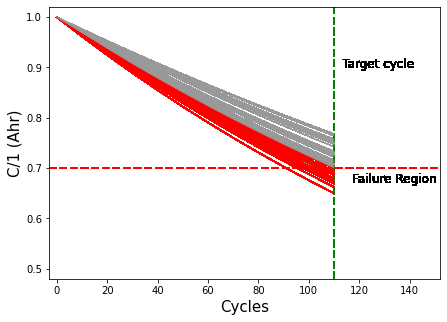

In [118]:
# Display trajectories in animation
fig, ax = plt.subplots(figsize=(7,5))
ax.set(xlim=(-3, 152), ylim=(0.48, 1.02))

ax.set_xlabel('Cycles', fontsize=15)
ax.set_ylabel('C/1 (Ahr)', fontsize=15)

# Initiate camera
camera = Camera(fig)

for i in range(samples.shape[0]):
               
    for j in range(cycle_steps.shape[0]):
    
        # Plot risk line
        ax.plot([-3, 152], [0.7, 0.7], '--r', lw=2)
        ax.text(117,0.67,'Failure Region', fontsize=12)
        
        # Plot target cycle
        ax.plot([target_cycle, target_cycle], [0.48, 1.02], '--g', lw=2)
        ax.text(target_cycle+3,0.9,'Target cycle', fontsize=12)
        
        # Plot trajectpry (red signifies a failed path)
        x = cycle_steps[0:j+1]
        y = ensemble_path[i][0:j+1]
        if i in failed_index:     
            ax.plot(x, y, color='r', lw=1.2)
        else:
            ax.plot(x, y, color=(0.6,0.6,0.6), lw=0.6,)
            
        
        # Mark failed path in red
        for accu_path in range(i):
            if accu_path in failed_index:  
                ax.plot(cycle_steps, ensemble_path[accu_path], color='r', lw=1.2)
            else:
                ax.plot(cycle_steps, ensemble_path[accu_path], color=(0.6,0.6,0.6), lw=0.6)
            
        
#         for failed in failed_index:
#             if failed<i:
#                 ax.plot(cycle_steps, ensemble_path[failed], color='r', lw=1.2, linestyle='-')
            
        
        # Capture frame
        camera.snap()
        
anim = camera.animate(interval = 30, repeat = False, repeat_delay = 500)

In [ ]:
HTML(anim.to_html5_video())